In the analysis of neuroimaging data using general linear models (GLMs), it is often common to find that regressors of interest
are correlated with one another.  While this inflates the variance of the estimated parameters, the GLM ensures that the 
estimated parameters only reflect the unique variance associated with the particular regressor; any shared variance
between regressors, while accounted for in the total model variance, is not reflected in the individual parameter 
estimates.  In general, this is as it should be; when it is not possible to uniquely attribute variance to any
particular regressor, then it should be left out.  

Unfortunately, there is a tendency within the fMRI literature to overthrow this feature of the GLM by "orthogonalizing"
variables that are correlated.  This, in effect, assigns the shared variance to one of the correlated variables based 
on the experimenter's decision.  While statistically valid, this raises serious conceptual concerns about the 
interpretation of the resulting parameter estimates.

The first point to make is that, contrary to claims often seen in fMRI papers, the presence of correlated regressors
does not require the use of orthogonalization; in fact, in our opinion there are very few cases in which it is appropriate
to use orthogonalization, and its use will most often result in problematic conclusions.

*What is orthogonalization?*

As an example of how the GLM deals with correlated regressors and how this is affected by orthogonalization,
we first generate some synthetic data to work with.

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)

npts=100
X = np.random.multivariate_normal([0,0],[[1,0.5],[0.5,1]],npts)
X = X-np.mean(X,0)  

params  = [1,2]
y_noise = 0.2
Y = np.dot(X,params) + y_noise*np.random.randn(npts)
Y = Y-np.mean(Y)    # remove mean so we can skip ones in design mtx

Populating the interactive namespace from numpy and matplotlib


Plot the relations between the two columns in X and the Y variable.

correlation(X[0],Y)) = 0.784
correlation(X[1],Y)) = 0.933


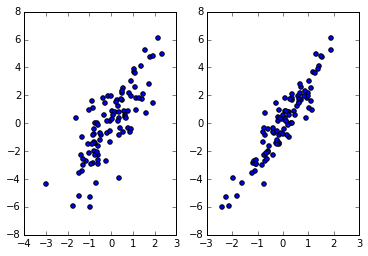

In [2]:
for i in range(2):
    print 'correlation(X[%d],Y))'%i, '= %4.3f' % np.corrcoef(X[:,i],Y)[0,1]
    plt.subplot(1,2,i+1)
    plt.scatter(X[:,i],Y)

Now let's compute the parameters for the two columns in X using linear regression.  They should come out very close
to the values specified for params above.

In [3]:
params_est =  np.linalg.lstsq(X,Y)[0]

print params_est

[ 1.01  2.  ]


Now let's orthogonalize the second regressor (X[1]) with respect to the first (X[0]) and create a new orthogonalized 
design matrix X_orth.  One way to do this is to fit a regression and then take the residuals.

In [4]:
x0_slope=numpy.linalg.lstsq(X[:,0].reshape((npts,1)),X[:,1].reshape((npts,1)))[0]

X_orth=X.copy()

X_orth[:,1]=X[:,1] - X[:,0]*x0_slope
print 'Correlation matrix for original design matrix'
print numpy.corrcoef(X.T)

print 'Correlation matrix for orthogonalized design matrix'
print numpy.corrcoef(X_orth.T)

Correlation matrix for original design matrix
[[ 1.    0.52]
 [ 0.52  1.  ]]
Correlation matrix for orthogonalized design matrix
[[  1.00e+00  -1.07e-16]
 [ -1.07e-16   1.00e+00]]


As intended, the correlation between the two regressors is effectively zero after orthogonalization. Now 
let's estimate the model parameters using the orthogonalized design matrix:

In [5]:
params_est_orth =  numpy.linalg.lstsq(X_orth,Y)[0]

print params_est_orth

[ 1.93  2.  ]


Note that the parameter estimate for the orthogonalized regressor is exactly the same as it was in the original model;
it is only the estimate for the other (orthogonalized-against) regressor that changes after orthogonalization.  That's
because shared variance between the two regressors has been assigned to X[0], whereas previously it was unassigned.

Note also that testing the second regressor will yield exactly the same test value. Testing for the first regressor, on the contrary, will yield a much smaller p value as the variance explained by this regressor contains the shared variance of both regressors.  

More generally, orthogonalizing the two first regressors $X_0$ of the design matrix $X$ will look like:

In [6]:
# Make X nptsx10
X = np.random.normal(0,1,(npts,10))
X = X - X.mean(axis=0)
X0 = X[:,:2]
X1 = X[:,2:]

# Orthogonolizing X0 with respect to X1: 
X0_orthog_wrt_X1 = X0 - np.dot(X1,np.linalg.pinv(X1)).dot(X0)

# reconstruct the new X matrix : Xorth
Xorth = np.hstack((X0_orthog_wrt_X1, X1))

# checking that the covariance of the two first regressors with others is 0
# look at the 5 first regressors
print np.corrcoef(Xorth.T)[:5,:5]

[[  1.00e+00   1.01e-01   5.57e-17   7.50e-17   6.37e-17]
 [  1.01e-01   1.00e+00  -1.44e-17   8.34e-18   9.09e-17]
 [  5.57e-17  -1.44e-17   1.00e+00   1.14e-02  -1.08e-03]
 [  7.50e-17   8.34e-18   1.14e-02   1.00e+00  -9.48e-02]
 [  6.37e-17   9.09e-17  -1.08e-03  -9.48e-02   1.00e+00]]
